# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel, DD03SpeciationModel

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=100, pop_size = 10):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    elevation = X + r.rand(*Y.shape)
    environment = np.stack([elevation])
    if trait_comp:
        model = DD03SpeciationModel(X, Y, pop_size, birth_rate=1, movement_rate=5, 
                                 slope_trait_env= [0.95, -0.95],
                                 car_cap_max=250, sigma_env_trait=0.2, 
                                 mut_prob=0.05, sigma_mut=0.05, sigma_mov=5, sigma_comp_trait=0.9, 
                                 sigma_comp_dist=0.1, random_seed=1234)
    else:
        model = IR12SpeciationModel(X, Y, pop_size, nb_radius=50, car_cap=25,
                                 slope_trait_env = [0.95, -0.95],
                                 sigma_env_trait=0.2, sigma_mov=5, sigma_mut=0.05,
                                 mut_prob=0.05, random_seed=1234)

    model.initialize([[0.5, 0.5]])
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(environment, [elevation.min()], [elevation.max()], 1)
        dfs.append(model.to_dataframe())
        model.update_individuals(1)
    return pd.concat(dfs).reset_index(drop=True), elevation, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between -10 and 10 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        kernel = sc.gaussian_kde(ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values)
        dists[tip] = kernel(points)
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 10)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]

        # fill histogram with slightly overlapping histograms
        ax1.fill(
            points, probs / probs.max() * 1.25,
            baseline=[tip] * len(points),
            style={"fill": color, "stroke": "white", "stroke-width": 0.5},
            title=tipname,
        )

        # add horizontal line at base
        ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

In [6]:
ind_dtf1

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,110.251531,15.034664,1,0,24,0.962103,0.500000
1,0,0.0,0.0,152.467702,170.922227,1,0,22,0.880864,0.500000
2,0,0.0,0.0,215.905324,167.809505,1,0,3,0.224561,0.500000
3,0,0.0,0.0,215.939418,152.754495,1,0,3,0.227340,0.500000
4,0,0.0,0.0,168.720328,15.034328,1,0,18,0.703322,0.500000
...,...,...,...,...,...,...,...,...,...,...
16137,99,99.0,0.0,20.236980,46.970977,525,509,1,0.732193,0.260045
16138,99,99.0,0.0,102.021351,38.362340,525,509,1,0.853411,0.301619
16139,99,99.0,0.0,76.019331,102.100566,523,516,1,0.903601,0.403946
16140,99,99.0,0.0,152.506926,96.755508,530,511,1,0.909373,0.519558


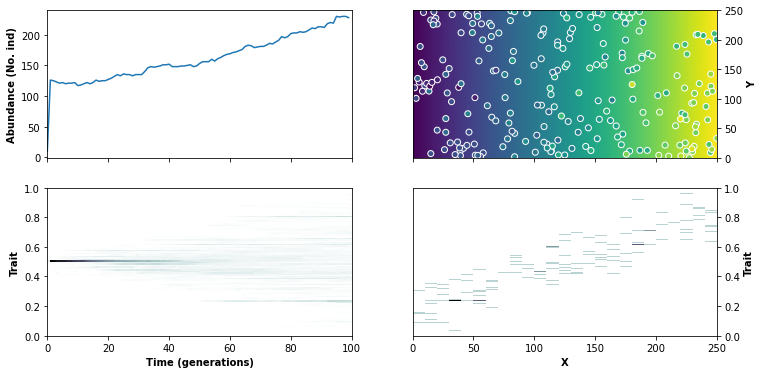

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.499719,126,node
2,2.0,3,2,0.499189,125,node
3,3.0,4,3,0.498720,123,node
4,4.0,5,4,0.500381,121,node
...,...,...,...,...,...,...
525,99.0,526,510,0.265286,17,leaf
526,99.0,527,514,0.077805,8,leaf
527,99.0,528,513,0.461207,17,leaf
528,99.0,529,512,0.500591,11,leaf


In [9]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()
toytree_plot(tree1, ind_dtf1)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t7019358679f741789036f151d9fb2f87"> <polygon points="200.0,73.07692307692307 201.53061224489795,73.07692307692307 203.0612244897959,73.07692307692307 204.59183673469389,73.07692307692307 206.12244897959187,73.07692307692307 207.6530612244898,73.07692307692307 209.18367346938774,73.07692307692307 210.71428571428572,73.07692307692307 212.24489795918367,73.07692307692307 213.77551020408163,73.07692307692307 215.30612244897958,73.07692307692307 216.83673469387753,73.07692307692307 218.36734693877548,73.07692307692307 219.8979591836735,73.07692307692307 221.42857142857144,73.07692307692307 222.9591836734694,73.07692307692307 224.48979591836735,73.07692307692307 226.0204081632653,73.07692307692307 227.55102040816325,73.07692307692307 229.0816326530612,73.07692307692307 230.61224489795916,73.07692307692307 232.1428571428571,73.07692307692307 233.6734693877551,73.07692307692307 235.20408163265304,73.07692307692307 236.73469387755102,73.07692307692307 238.26530612244898,73.07692307692307 239.79591836734693,73.07692307692307 241.3265306122449,73.07692307692307 242.85714285714286,73.07692307692307 244.3877551020408,73.07692307692307 245.91836734693877,73.07692307692307 247.44897959183675,73.07692307692307 248.9795918367347,73.07692307692307 250.51020408163265,73.07692307692307 252.0408163265306,73.07692307692307 253.57142857142858,73.07692307692307 255.10204081632654,73.07692307692307 256.6326530612245,73.07692307692307 258.16326530612247,73.07692307692307 259.6938775510204,73.07692307692307 261.2244897959184,73.07692307692307 262.7551020408163,73.07692307692307 264.2857142857143,73.07692307692307 265.81632653061223,73.07692307692307 267.3469387755102,73.07692307692307 268.8775510204082,73.07692307692307 270.4081632653061,73.07692307692307 271.9387755102041,73.07692307692307 273.469387755102,73.07692307692307 275.0,73.07692307692307 275.0,73.07692307692307 273.469387755102,73.07692307692307 271.9387755102041,73.07692307692307 270.4081632653061,73.07692307692287 268.8775510204082,73.07692307682846 267.3469387755102,73.07692305463445 265.81632653061223,73.07692049029448 264.2857142857143,73.07677517191605 262.7551020408163,73.07275053846261 261.2244897959184,73.01857604553066 259.6938775510204,72.66558377676209 258.16326530612247,71.52416151713112 256.6326530612245,69.32336600151902 255.10204081632654,65.34833917342505 253.57142857142858,58.69074480326327 252.0408163265306,51.836634589966245 250.51020408163265,47.86153724553011 248.9795918367347,45.697639077014564 247.44897959183675,44.230769230769255 245.91836734693877,47.315936770438086 244.3877551020408,57.51700957275377 242.85714285714286,67.3584017413047 241.3265306122449,71.03972728905282 239.79591836734693,70.95992006814282 238.26530612244898,71.0089744073711 236.73469387755102,72.0312201835947 235.20408163265304,72.81578351084138 233.6734693877551,73.04480307946085 232.1428571428571,73.07497749718299 230.61224489795916,73.07686504203697 229.0816326530612,73.0769222244208 227.55102040816325,73.07692307075617 226.0204081632653,73.07692307690111 224.48979591836735,73.07692307692302 222.9591836734694,73.07692307692307 221.42857142857144,73.07692307692307 219.8979591836735,73.07692307692307 218.36734693877548,73.07692307692307 216.83673469387753,73.07692307692307 215.30612244897958,73.07692307692307 213.77551020408163,73.07692307692307 212.24489795918367,73.07692307692307 210.71428571428572,73.07692307692307 209.18367346938774,73.07692307692307 207.6530612244898,73.07692307692307 206.1

## Tree summary statistics 

Phylogenetic diversity (PD)

In [10]:
sum(tree1.calc_node_root_distances())

1287.0

In [11]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [12]:
pdm1.mean_pairwise_distance()

125.12820512820512

Mean neighbor taxon distance (MNTD)

In [13]:
pdm1.mean_nearest_taxon_distance()

46.0

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

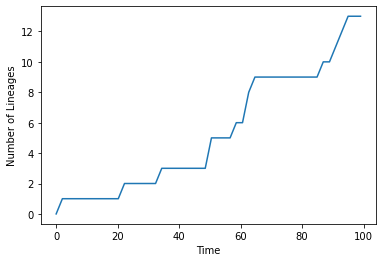

In [14]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [15]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

In [16]:
ind_dtf2

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0
0,0,0.0,0.0,110.251531,15.034664,1,0,1,M,0.044522,0.500000
1,0,0.0,0.0,152.467702,170.922227,1,0,1,M,0.045017,0.500000
2,0,0.0,0.0,215.905324,167.809505,1,0,1,M,0.073930,0.500000
3,0,0.0,0.0,215.939418,152.754495,1,0,1,M,0.074605,0.500000
4,0,0.0,0.0,168.720328,15.034328,1,0,2,B,0.046195,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
20191,99,99.0,1.0,236.950973,94.393507,409,395,2,B,2.651003,0.415263
20192,99,99.0,1.0,213.948672,79.663737,409,395,0,D,2.276077,0.354179
20193,99,99.0,1.0,43.886436,123.684688,409,395,1,M,1.107820,0.463627
20194,99,99.0,1.0,78.728446,52.725935,409,395,1,M,1.110010,0.495772


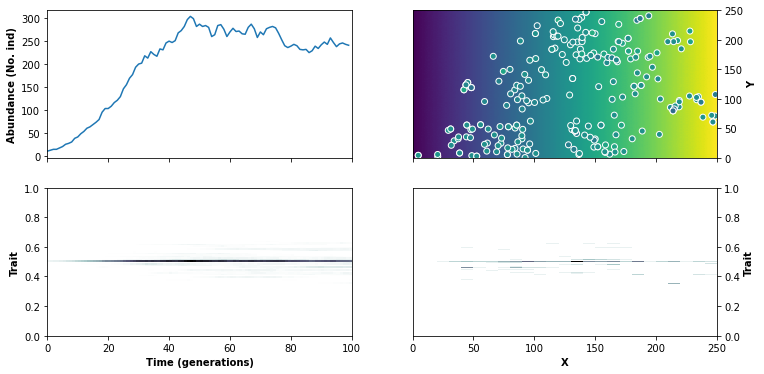

In [17]:
plot_sol(ind_dtf2, elevation2, X2)

In [18]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.500000,12,node
2,2.0,3,2,0.500000,14,node
3,3.0,4,3,0.500000,14,node
4,4.0,5,4,0.500000,17,node
...,...,...,...,...,...,...
407,99.0,408,400,0.482929,18,leaf
408,99.0,409,395,0.489774,71,leaf
409,99.0,410,398,0.499058,42,leaf
410,99.0,411,396,0.488456,9,leaf


In [19]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()
toytree_plot(tree2, ind_dtf2)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2a786b8435154bf7b954773c8d2d95cf"> <polygon points="200.0,83.33333333333334 201.53061224489795,83.33333333333334 203.0612244897959,83.33333333333334 204.59183673469389,83.33333333333334 206.12244897959187,83.33333333333334 207.6530612244898,83.33333333333334 209.18367346938774,83.33333333333334 210.71428571428572,83.33333333333334 212.24489795918367,83.33333333333334 213.77551020408163,83.33333333333334 215.30612244897958,83.33333333333334 216.83673469387753,83.33333333333334 218.36734693877548,83.33333333333334 219.8979591836735,83.33333333333334 221.42857142857144,83.33333333333334 222.9591836734694,83.33333333333334 224.48979591836735,83.33333333333334 226.0204081632653,83.33333333333334 227.55102040816325,83.33333333333334 229.0816326530612,83.33333333333334 230.61224489795916,83.33333333333334 232.1428571428571,83.33333333333334 233.6734693877551,83.33333333333334 235.20408163265304,83.33333333333334 236.73469387755102,83.33333333333334 238.26530612244898,83.33333333333334 239.79591836734693,83.33333333333334 241.3265306122449,83.33333333333334 242.85714285714286,83.33333333333334 244.3877551020408,83.33333333333334 245.91836734693877,83.33333333333334 247.44897959183675,83.33333333333334 248.9795918367347,83.33333333333334 250.51020408163265,83.33333333333334 252.0408163265306,83.33333333333334 253.57142857142858,83.33333333333334 255.10204081632654,83.33333333333334 256.6326530612245,83.33333333333334 258.16326530612247,83.33333333333334 259.6938775510204,83.33333333333334 261.2244897959184,83.33333333333334 262.7551020408163,83.33333333333334 264.2857142857143,83.33333333333334 265.81632653061223,83.33333333333334 267.3469387755102,83.33333333333334 268.8775510204082,83.33333333333334 270.4081632653061,83.33333333333334 271.9387755102041,83.33333333333334 273.469387755102,83.33333333333334 275.0,83.33333333333334 275.0,83.33333333333334 273.469387755102,83.33333333333334 271.9387755102041,83.33333333333334 270.4081632653061,83.33333333333334 268.8775510204082,83.33333333333334 267.3469387755102,83.33333333333334 265.81632653061223,83.33333333333334 264.2857142857143,83.33333333333334 262.7551020408163,83.33333333333334 261.2244897959184,83.33333333333334 259.6938775510204,83.33333333333334 258.16326530612247,83.33333333333334 256.6326530612245,83.33333333333334 255.10204081632654,83.33333333333185 253.57142857142858,83.33333333021073 252.0408163265306,83.3333312938685 250.51020408163265,83.33292528056322 248.9795918367347,83.30832300101865 247.44897959183675,82.86373342633726 245.91836734693877,80.63173169696438 244.3877551020408,78.5412303541141 242.85714285714286,80.09087906845812 241.3265306122449,77.41055559229164 239.79591836734693,61.62374325986129 238.26530612244898,41.6666666666667 236.73469387755102,47.73957427251339 235.20408163265304,65.58261343413832 233.6734693877551,76.10434717618826 232.1428571428571,81.90961731489335 230.61224489795916,83.23916126612889 229.0816326530612,83.33138455307244 227.55102040816325,83.33332084668623 226.0204081632653,83.33333330861112 224.48979591836735,83.33333333331822 222.9591836734694,83.33333333333334 221.42857142857144,83.33333333333334 219.8979591836735,83.33333333333334 218.36734693877548,83.33333333333334 216.83673469387753,83.33333333333334 215.30612244897958,83.33333333333334 213.77551020408163,83.33333333333334 212.24489795918367,83.33333333333334 210.71428571428572,83.33333333333334 209.18367346938774,83.33333333333334 207.6530612244898,83.33333333333334 206.1224

## Tree summary statistics 

Phylogenetic diversity (PD)

In [20]:
sum(tree2.calc_node_root_distances())

891.0

In [21]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [22]:
pdm2.mean_pairwise_distance()

90.0

Mean neighbor taxon distance (MNTD)

In [23]:
pdm2.mean_nearest_taxon_distance()

71.55555555555556

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

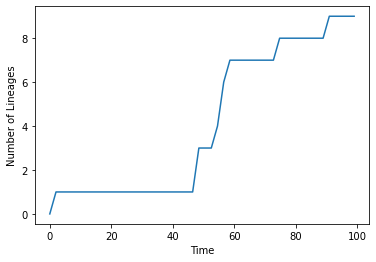

In [24]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')